In [1]:
import json
import pandas as pd

# Load JSON file
with open("youtube_data_vangogh_expanded.json", "r", encoding="utf-8") as f:
    data = json.load(f)

# Extract top-level list
videos = data["youtube"]

# Flatten all comments and replies
all_comments = []

for video in videos:
    video_id = video.get("video_id")
    video_title = video.get("title")
    video_comments = video.get("comments", [])

    for comment in video_comments:
        # Top-level comment
        all_comments.append({
            "video_id": video_id,
            "video_title": video_title,
            "author": comment.get("author"),
            "text": comment.get("text"),
            "likes": comment.get("likes"),
            "published_at": comment.get("published_at"),
            "reply": False
        })

        # Any replies?
        for reply in comment.get("replies", []):
            all_comments.append({
                "video_id": video_id,
                "video_title": video_title,
                "author": reply.get("author"),
                "text": reply.get("text"),
                "likes": reply.get("likes"),
                "published_at": reply.get("published_at"),
                "reply": True
            })

# Create DataFrame
df_youtube = pd.DataFrame(all_comments)

# Preview
print(df_youtube.head())


      video_id                                        video_title  \
0  4fwDVlnoC98  Van Gogh’s Mental Illness:  Was Epilepsy Respo...   
1  4fwDVlnoC98  Van Gogh’s Mental Illness:  Was Epilepsy Respo...   
2  4fwDVlnoC98  Van Gogh’s Mental Illness:  Was Epilepsy Respo...   
3  4fwDVlnoC98  Van Gogh’s Mental Illness:  Was Epilepsy Respo...   
4  4fwDVlnoC98  Van Gogh’s Mental Illness:  Was Epilepsy Respo...   

               author                                               text  \
0     @peterdavies777  This is my favourite artist, maybe its not a s...   
1       @vcwloves9864  I had a really violent seizure a few years bac...   
2      @CreativaArtly  As someone with epilepsy as well, I definitely...   
3  @claudesilverio677  Epileptic  States can be provoced by thujon, t...   
4  @jessicabiddle9696  I wonder if autism was any bit related. Epilep...   

   likes          published_at  reply  
0      0  2025-04-16T09:04:26Z  False  
1      0  2024-12-18T14:34:45Z  False  
2      0

In [24]:
df_youtube.tail()

,video_id,video_title,author,text,likes,published_at,reply,sentiment,event_type
81429,jwMD4wSsODI,What needs to change in media depictions of sc...,@magicalmadness143,That is crazy to say to someone.. I hope you a...,1,2022-01-07 21:31:33,True,0.7579,none
81430,jwMD4wSsODI,What needs to change in media depictions of sc...,@LeanderLenny,Rehabilitate yourself! Never give up! I've got...,1,2022-01-08 22:53:13,True,-0.8507,none
81431,jwMD4wSsODI,What needs to change in media depictions of sc...,@brindmusicnerd,Well said 👍👏💚,3,2022-01-07 17:16:17,False,0.7430,none
81432,jwMD4wSsODI,What needs to change in media depictions of sc...,@cjolena,Oh no not the red yarn!!! Quick Alicia!!! . Na...,1,2022-01-07 16:59:09,False,0.7243,none
81433,jwMD4wSsODI,What needs to change in media depictions of sc...,@pointcuration1278,"Having schizophrenia doesn't make you crazy, n...",13,2022-01-07 16:55:03,False,0.4449,none


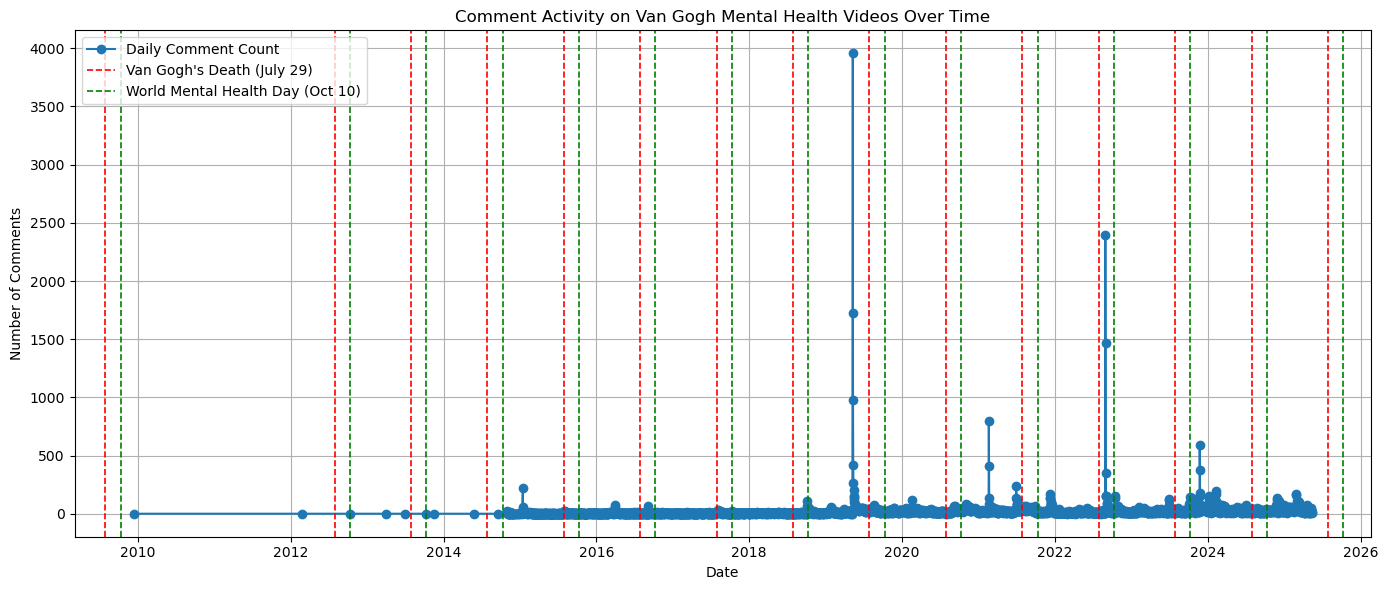

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your dataset
df = df_youtube  # Replace with your actual file

# Convert published_at to datetime
df['published_at'] = pd.to_datetime(df['published_at'])

# Group comment count by day
daily_counts = df.groupby(df['published_at'].dt.date).size().reset_index(name='comment_count')
daily_counts['published_at'] = pd.to_datetime(daily_counts['published_at'])

# Plotting
plt.figure(figsize=(14, 6))
plt.plot(daily_counts['published_at'], daily_counts['comment_count'], marker='o', linestyle='-', label='Daily Comment Count')

# Highlight Van Gogh’s death anniversary (July 29)
for year in daily_counts['published_at'].dt.year.unique():
    plt.axvline(pd.Timestamp(f'{year}-07-29'), color='red', linestyle='--', linewidth=1.2,
                label="Van Gogh's Death (July 29)" if year == daily_counts['published_at'].dt.year.min() else "")

# Highlight World Mental Health Day (October 10)
for year in daily_counts['published_at'].dt.year.unique():
    plt.axvline(pd.Timestamp(f'{year}-10-10'), color='green', linestyle='--', linewidth=1.2,
                label="World Mental Health Day (Oct 10)" if year == daily_counts['published_at'].dt.year.min() else "")


plt.title("Comment Activity on Van Gogh Mental Health Videos Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Comments")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [5]:
top_days = daily_counts.sort_values('comment_count', ascending=False).head(5)
print(top_days)



     published_at  comment_count
1530   2019-05-11           3956
2736   2022-08-30           2395
1529   2019-05-10           1727
2737   2022-08-31           1470
1531   2019-05-12            974


In [7]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()
df['sentiment'] = df['text'].apply(lambda x: analyzer.polarity_scores(str(x))['compound'])


In [8]:
## Calculate daily average sentiment
df_daily_sentiment = df.groupby(df['published_at'].dt.date)['sentiment'].mean().reset_index()
df_daily_sentiment['published_at'] = pd.to_datetime(df_daily_sentiment['published_at'])


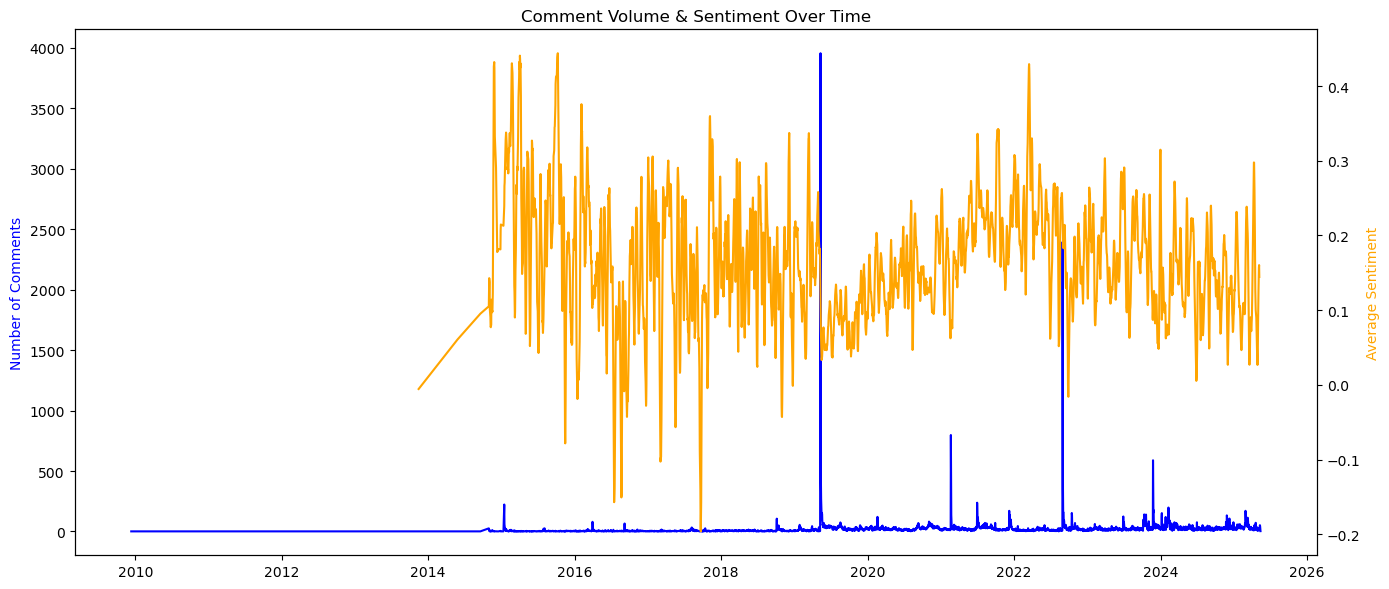

In [15]:

# Plot it on a second axis
fig, ax1 = plt.subplots(figsize=(14, 6))

# Comment count
ax1.plot(daily_counts['published_at'], daily_counts['comment_count'], color='blue', label='Daily Comments')
ax1.set_ylabel("Number of Comments", color='blue')

# Average sentiment
ax2 = ax1.twinx()
ax2.plot(df_daily_sentiment['published_at'], df_daily_sentiment['sentiment'], color='orange', label='Avg Sentiment')
ax2.set_ylabel("Average Sentiment", color='orange')

plt.title("Comment Volume & Sentiment Over Time")
fig.tight_layout()
plt.show()


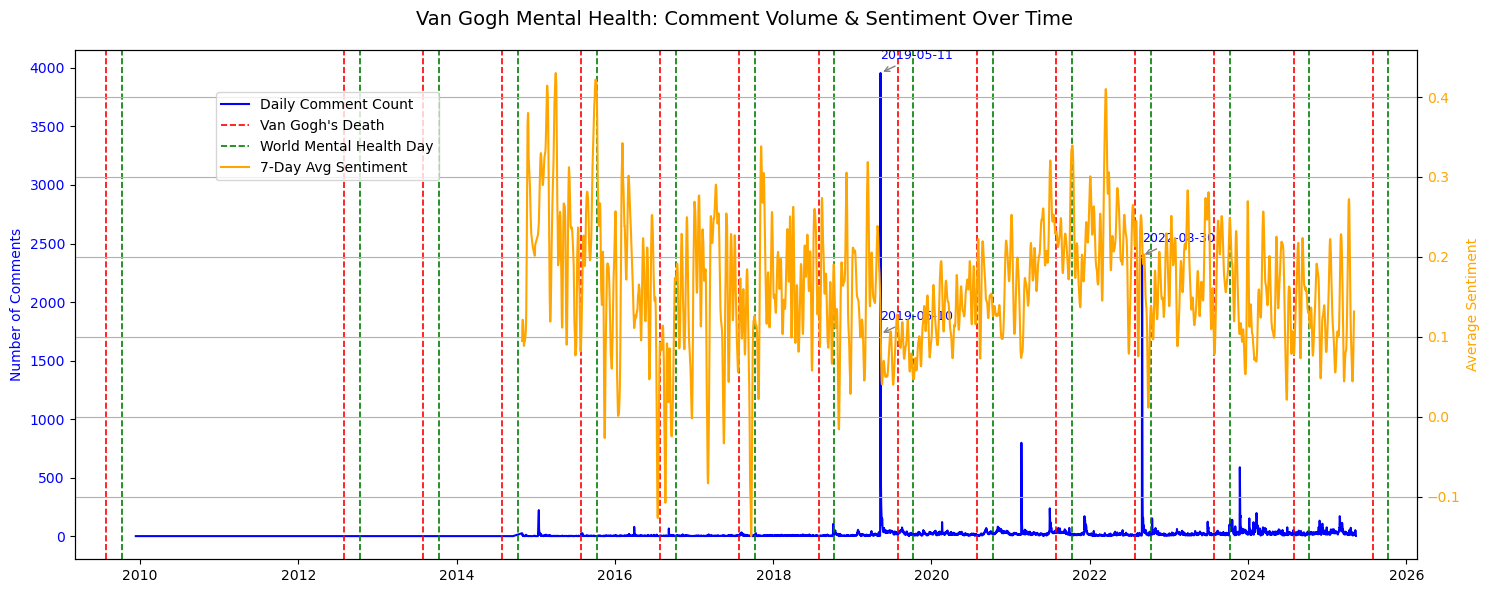

In [16]:
# Smooth sentiment with 7-day rolling average
df_daily_sentiment['sentiment'] = df_daily_sentiment['sentiment'].rolling(window=7, center=True).mean()

# Merge both datasets
combined = pd.merge(daily_counts, df_daily_sentiment, on='published_at', how='inner')

# --- Plotting ---
fig, ax1 = plt.subplots(figsize=(15, 6))

# Comment volume (blue)
ax1.plot(combined['published_at'], combined['comment_count'], color='blue', label='Daily Comment Count')
ax1.set_ylabel("Number of Comments", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Annotate top 3 spikes
top_spikes = combined.sort_values('comment_count', ascending=False).head(3)
for _, row in top_spikes.iterrows():
    ax1.annotate(
        f"{row['published_at'].date()}",
        xy=(row['published_at'], row['comment_count']),
        xytext=(0, 10),
        textcoords='offset points',
        color='blue',
        fontsize=9,
        arrowprops=dict(arrowstyle='->', color='gray')
    )

# Sentiment (orange, on second axis)
ax2 = ax1.twinx()
ax2.plot(combined['published_at'], combined['sentiment'], color='orange', label='7-Day Avg Sentiment')
ax2.set_ylabel("Average Sentiment", color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Overlay vertical lines for July 29 and Oct 10
for year in combined['published_at'].dt.year.unique():
    ax1.axvline(pd.Timestamp(f'{year}-07-29'), color='red', linestyle='--', linewidth=1.2,
                label="Van Gogh's Death" if year == combined['published_at'].dt.year.min() else "")
    ax1.axvline(pd.Timestamp(f'{year}-10-10'), color='green', linestyle='--', linewidth=1.2,
                label="World Mental Health Day" if year == combined['published_at'].dt.year.min() else "")


# Title and Legend
fig.suptitle("Van Gogh Mental Health: Comment Volume & Sentiment Over Time", fontsize=14)
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.93), bbox_transform=ax1.transAxes)
fig.tight_layout()
plt.grid(True)
plt.show()

In [17]:
# Filter to just that day
spike_day = pd.to_datetime("2019-05-11")
spike_data = df[df['published_at'].dt.date == spike_day.date()]

# View top video titles by comment count
top_videos = spike_data['video_title'].value_counts().head(5)
print(top_videos)


video_title
The Curious Death Of Vincent Van Gogh                                        3890
Vincent Van Gogh Visits the Gallery | Vincent and the Doctor | Doctor Who      44
Van Gogh – Challenging the &#39;Tortured Genius&#39; Myth | Tate               21
Van Gogh&#39;s death                                                            1
Name: count, dtype: int64


In [18]:
# Identify top 5 spike days
top_spike_days = combined.sort_values("comment_count", ascending=False).head(5)

# Extract top video title per spike day
spike_details = []
for date in top_spike_days['published_at']:
    day_df = df[df['published_at'].dt.date == date.date()]
    top_title = day_df['video_title'].value_counts().idxmax()
    spike_details.append({
        'date': date.date(),
        'comment_count': len(day_df),
        'top_video_title': top_title
    })

# Convert to DataFrame and export
spike_df = pd.DataFrame(spike_details)
spike_df.to_csv("top_spike_days_with_titles.csv", index=False)
print(spike_df)


         date  comment_count                              top_video_title
0  2019-05-11           3956        The Curious Death Of Vincent Van Gogh
1  2022-08-30           2395  The Mystery of Vincent Van Gogh&#39;s Death
2  2019-05-10           1727        The Curious Death Of Vincent Van Gogh
3  2022-08-31           1470  The Mystery of Vincent Van Gogh&#39;s Death
4  2019-05-12            974        The Curious Death Of Vincent Van Gogh


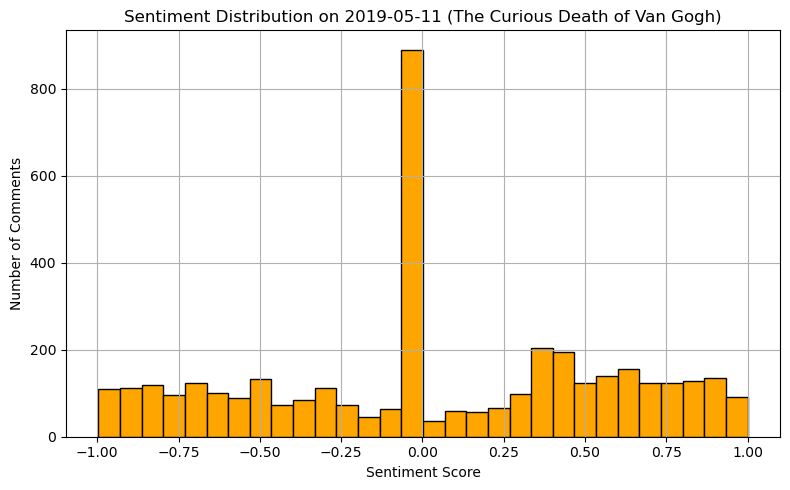

In [19]:
spike_day = pd.to_datetime("2019-05-11")
sentiments_on_spike = df[df['published_at'].dt.date == spike_day.date()]['sentiment']

# Histogram
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.hist(sentiments_on_spike, bins=30, color='orange', edgecolor='black')
plt.title("Sentiment Distribution on 2019-05-11 (The Curious Death of Van Gogh)")
plt.xlabel("Sentiment Score")
plt.ylabel("Number of Comments")
plt.grid(True)
plt.tight_layout()
plt.show()


In [21]:
# Ensure datetime is tz-naive
df['published_at'] = pd.to_datetime(df['published_at']).dt.tz_localize(None)

# Helper to check if a date is near a key event (±3 days)
def is_near_event(date, event_str, window=3):
    for year in range(df['published_at'].dt.year.min(), df['published_at'].dt.year.max() + 1):
        event_date = pd.Timestamp(f"{year}-{event_str}")
        if abs((date - event_date).days) <= window:
            return True
    return False

# Classify each date
df['event_type'] = df['published_at'].apply(
    lambda x: 'death_anniv' if is_near_event(x, '07-29') else (
              'mental_health_day' if is_near_event(x, '10-10') else 'none')
)

# Group by event type and describe sentiment
event_sentiment_summary = df[df['event_type'] != 'none'].groupby('event_type')['sentiment'].describe()
print(event_sentiment_summary)


                    count      mean       std     min     25%     50%  \
event_type                                                              
death_anniv         998.0  0.132529  0.500941 -0.9942 -0.1531  0.0000   
mental_health_day  1429.0  0.196074  0.495320 -0.9915 -0.0258  0.1913   

                        75%     max  
event_type                           
death_anniv        0.568625  0.9968  
mental_health_day  0.636900  0.9906  


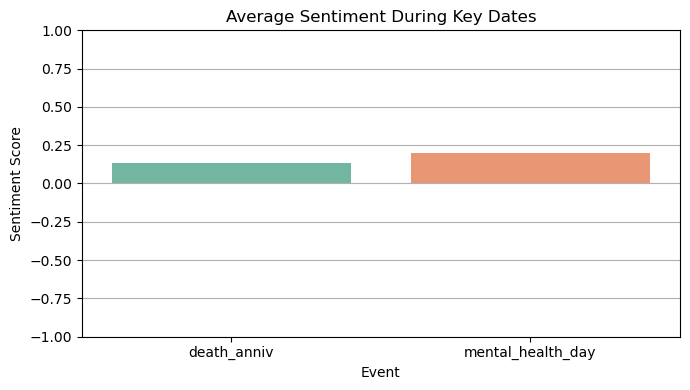

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

# Average sentiment per event type
avg_sent = df[df['event_type'] != 'none'].groupby('event_type')['sentiment'].mean().reset_index()

# Plot
plt.figure(figsize=(7, 4))
sns.barplot(data=avg_sent, x='event_type', y='sentiment', palette='Set2')
plt.title("Average Sentiment During Key Dates")
plt.ylabel("Sentiment Score")
plt.xlabel("Event")
plt.ylim(-1, 1)
plt.grid(axis='y')
plt.tight_layout()
plt.show()
